<a href="https://colab.research.google.com/github/saisrigundam/GB_730_Portfolio_Optimization/blob/main/%5BGB_730%5D_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set-Up

In [ ]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo.
#Uncomment the appropriate solver that you need.
#for reference, see https://colab.research.google.com/drive/1yGk8RB5NXrcx9f1Tb-oCiWzbxh61hZLI?usp=sharing

#installing and importing pyomo
!pip install -q pyomo
from pyomo.environ import *

#!pip install PyPortfolioOpt
###installing and importing specific solvers (uncomment the one(s) you need)
###glpk
#!apt-get install -y -qq glpk-utils
###cbc
#!apt-get install -y -qq coinor-cbc
###ipopt
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
###bonmin
#!wget -N -q "https://ampl.com/dl/open/bonmin/bonmin-linux64.zip"
#!unzip -o -q bonmin-linux64
###couenne
#!wget -N -q "https://ampl.com/dl/open/couenne/couenne-linux64.zip"
#!unzip -o -q couenne-linux64
###geocode
#!wget -N -q "https://ampl.com/dl/open/gecode/gecode-linux64.zip"
#!unzip -o -q gecode-linux64

#Using the solvers:
#SolverFactory('glpk', executable='/usr/bin/glpsol')
#SolverFactory('cbc', executable='/usr/bin/cbc')
#SolverFactory('ipopt', executable='/content/ipopt')
#SolverFactory('bonmin', executable='/content/bonmin')
#SolverFactory('couenne', executable='/content/couenne')
#SolverFactory('gecode', executable='/content/gecode')


#installing and importing pyomo
!pip install -q pyomo
from pyomo.environ import *

###ipopt
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

     |████████████████████████████████| 11.1 MB 5.1 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 


In [ ]:
import pandas as pd

In [ ]:
#upload the input stock data from excel
import io
from google.colab import files
uploaded = files.upload()
file = io.BytesIO(uploaded['returns.csv'])

Saving returns.csv to returns.csv


In [ ]:
was# Loading data from excel for 500 stocks into data frame
returns_data = pd.read_csv('returns.csv')
returns_data.head()

,Unnamed: 0,date,AAPL,MSFT,AMZN,GOOGL,BRK-B,GOOG,UNH,JNJ,...,LUMN,MHK,NWL,LNC,RL,FOX,DVA,DISH,VNO,NWS
0,0,2013-01-01,-0.144089,0.027705,0.058317,0.068294,0.080602,0.068294,0.021941,0.054493,...,0.053671,0.123687,0.054333,0.118919,0.113418,0.0,0.044151,0.052045,0.068771,0.0
1,1,2013-02-01,-0.030933,0.012751,-0.004633,0.060223,0.053957,0.060223,-0.031878,0.029627,...,-0.142892,0.042888,-0.005963,0.023743,0.041987,0.0,0.036479,-0.066023,-0.042074,0.0
2,2,2013-03-01,0.008699,0.037657,0.008400,-0.008749,0.019969,-0.008749,0.070346,0.079781,...,0.013268,0.066969,0.125645,0.103927,-0.023981,0.0,-0.008611,0.089081,0.042763,0.0
3,3,2013-04-01,0.000271,0.156939,-0.047582,0.038253,0.020346,0.038253,0.051610,0.045382,...,0.085928,-0.019802,0.009195,0.042931,0.075039,0.0,0.000506,0.034037,0.046868,0.0
4,4,2013-05-01,0.015696,0.054381,0.060636,0.056575,0.072893,0.056575,0.045053,-0.012320,...,-0.091030,0.002615,0.026576,0.052521,-0.035742,0.0,0.045681,-0.016586,-0.086912,0.0


In [ ]:
#input data for our model
num_DVs = len(returns_data.columns)-2
num_months = len(returns_data['date'])
risk_avg_return = [1,2,3,4,5]

In [ ]:
#function to simulate Markowitz Financial Portfolio
def solve_model( avg_return):
  model = ConcreteModel()
  model.x = Var(range(num_DVs),domain=NonNegativeReals)


  model.Objective = Objective(expr = sum(
      (sum(returns_data.iloc[i,j+2]* model.x[j] for j in range(num_DVs)) -
      (sum(sum(returns_data.iloc[i,j+2]* model.x[j] for j in range(num_DVs))
      for i in range(num_months))/num_months))**2 for i in range(num_months))/num_months
      , sense = minimize)

  model.constraint1 = ConstraintList()

  #each stock should not exceed more than 20%
  for i in range(num_DVs):
    model.constraint1.add(expr = model.x[i]<=20)

  #all the DVs should add to 100%
  model.constraint2 = Constraint(expr = (sum(model.x[i] for i in range(num_DVs)))==100)

  #Average return should be greater than or equal to threshold
  model.constraint3 = Constraint(expr = (sum(sum(returns_data.iloc[i,j+2]* model.x[j] for j in range(num_DVs)) for i in range(num_months))/num_months) >= avg_return)
  #solving
  opt = SolverFactory('ipopt', executable='/content/ipopt')
  opt.solve(model, tee=False)
  print('Avg Return:', avg_return)
  print('Variance:',model.Objective()/100)
  for i in range(num_DVs):
    if(model.x[i]()>0.01):
      print(returns_data.columns[i+2],':',round(model.x[i](),2))
  return model.Objective()/100

In [ ]:
#stocks for average return 5 without asset limit of 20%
solve_model(high_risk_avg_return)

Avg Return: 5
Variance: 1.1516691192641582
NVDA : 36.89
TSLA : 19.39
DXCM : 4.61
ENPH : 25.87
KDP : 4.87
ABMD : 8.36


In [ ]:
#stocks for average return 1 without asset limit of 20%
solve_model(low_risk_avg_return)

Avg Return: 1
Variance: 0.03502800275577362
MSFT : 2.58
LLY : 3.88
META : 0.39
NEE : 1.85
VZ : 0.41
TMUS : 0.42
REGN : 0.35
CME : 9.89
DG : 0.72
ATVI : 1.3
GIS : 4.38
BIIB : 3.32
NEM : 2.02
OTIS : 4.06
RMD : 1.91
CEG : 28.44
ODFL : 0.58
CMS : 2.45
CLX : 3.35
BALL : 1.37
SJM : 3.28
POOL : 0.13
DPZ : 2.55
MTCH : 1.28
LW : 4.35
HAS : 0.4
OGN : 11.35
AIZ : 2.99


In [ ]:
# if there is no solution
solve_model(20)

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


Avg Return: 20
Variance: 6.651575795897468
ENPH : 100.0


In [ ]:
#stocks for average return 5
solve_model(high_risk_avg_return)

Avg Return: 5
Variance: 1.722392239421411
NVDA : 20.0
TSLA : 20.0
AMD : 18.65
DXCM : 2.81
ENPH : 20.0
KDP : 18.54


In [ ]:
#different returns to check different variances
avg_var = []
for i in risk_avg_return:
  avg_var.append(solve_model(i))

Avg Return: 1
Variance: 0.03597320996423756
MSFT : 2.71
LLY : 3.86
META : 0.22
NEE : 3.2
TMUS : 0.63
REGN : 1.59
NOC : 0.16
CME : 11.05
DG : 1.29
ATVI : 1.05
GIS : 3.91
BIIB : 3.63
NEM : 2.13
ED : 0.63
OTIS : 8.44
RMD : 1.59
CEG : 20.0
ODFL : 0.26
MTB : 0.1
CTRA : 1.15
CMS : 2.47
CLX : 3.22
BALL : 0.43
SJM : 4.54
DPZ : 1.03
MTCH : 1.0
LW : 5.36
HAS : 0.9
OGN : 11.44
AIZ : 2.01
Avg Return: 2
Variance: 0.08282154453552894
MSFT : 2.82
UNH : 3.06
NVDA : 3.86
TSLA : 1.3
LLY : 15.73
AVGO : 0.04
NEE : 2.14
TMUS : 5.68
NOC : 9.49
PGR : 5.98
MRNA : 0.68
CME : 7.19
ATVI : 5.35
DXCM : 0.28
ENPH : 2.12
NEM : 0.11
RMD : 1.51
KDP : 0.2
CEG : 12.39
ODFL : 3.43
CTRA : 1.61
CMS : 7.06
MPWR : 2.41
PAYC : 0.12
DPZ : 2.35
LW : 2.65
MKTX : 0.43
Avg Return: 3
Variance: 0.2227180578769302
UNH : 4.74
NVDA : 12.49
TSLA : 4.81
LLY : 19.07
AVGO : 3.06
NFLX : 0.15
TMUS : 7.13
NOC : 16.75
PGR : 6.79
MRNA : 1.14
ATVI : 4.96
DXCM : 2.6
ENPH : 6.49
KDP : 0.95
MPWR : 4.29
ABMD : 3.14
PAYC : 1.45
Avg Return: 4
Variance

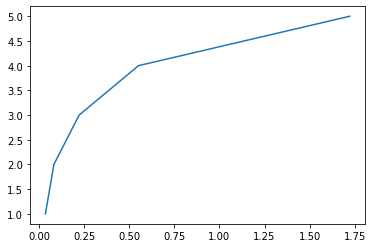

In [ ]:
#Plot effiecient frontier
import matplotlib.pyplot as plt
plt.plot( avg_var,risk_avg_return)